In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

import os
import glob
from collections import Counter

In [2]:
import sklearn
print(sklearn.__version__)


1.6.1


In [40]:
# 1 s windows with 50% overlap. Label with majority class. Rule = remove windows that don't have 90% same majority
def create_sliding_windows(df, window_length=1, stepsize=0.5):
    # initialize
    windows = [] # to save output
    start = df['Time'].min()
    end_time = df['Time'].max()

    while start + window_length <= end_time:
        end = start + window_length
        # create df per window
        window_df = df[(df['Time'] >= start) & (df['Time'] <= end)]

        # define majority event label
        labels = window_df['GeneralEvent'].tolist()
        label_counts = Counter(labels) # keeps count of elements in an iterable
        top_label, top_count = label_counts.most_common(1)[0]
        percentage = top_count/len(labels)

        # if 90% of same event label, keep window, add to output
        if percentage >= 0.95:
            windows.append({
                'start': start,
                'end': end,
                'label': top_label,
                'row indices': window_df.index.tolist()
            })

        # slide window
        start += stepsize

    return windows


In [41]:
def feature_extraction(df, participant_id, windows, features): 
    output_rows = []

    for i, window in enumerate(windows):
        window_data = df.loc[window['row indices'],features] # defines what data is in each window

        # define rows via dictionary 
        row = {
        'Participant': f'{participant_id}',
        'Window': i + 1,
        'GeneralEvent': window['label'] }

        # add to dictionary, column-specific operations
        for col in features:  # computing for every column, which separates X,Y,Z
            data = window_data[col]
            row[f'{col}_mean'] = data.mean()
            row[f'{col}_std'] = data.std()
            row[f'{col}_max'] = data.max()
            row[f'{col}_min'] = data.min()
            row[f'{col}_rms'] = np.sqrt(np.mean(np.square(data)))
            
            # peak counts and zero crossing require variable is oscilliatory: FreeAcc and Gyr only
            names = ['FreeAcc', 'Gyr']
            if any(name in col for name in names): # check if any substring in col matches either of the strings in name
                row[f'{col}_zerocross'] = ((data[:-1] * data[1:]) < 0).sum() # el-wise product of consecutive pairs. # num < 0 = # zerocross
                peaks, properties = find_peaks(data)
                row[f'{col}_peakcount'] = len(peaks) # peak count

        output_rows.append(row) # add to output
        features_df = pd.DataFrame(output_rows)

    return features_df

In [42]:
def preprocess(df, participant_id):

    # remove columns with NA
    df.dropna(axis=1, inplace=True)

    # fix Time data type
    df['Time'] = df['Time'].str.replace(" sec", "").astype(float)

    # create sliding windows
    windows = create_sliding_windows(df)

    # feature engineering per window
    # identify cols
    names = ['FreeAcc', 'Gyr', 'VelInc', 'Roll', 'Pitch', 'Yaw']
    chosen_variables = []

    for col in df.columns.tolist():
        for n in names:
            if n in col:
                chosen_variables.append(col)
    # extract feats
    wf_df = feature_extraction(df, participant_id, windows, chosen_variables)

    return wf_df

In [43]:
def get_pt_id(file_path):
    # get filename
    filename = os.path.basename(file_path)
    # split string, get all before '_tug'
    participant_id = filename.split('_tug')[0]
    return participant_id

In [92]:
# read in files from csv
csv_folder = r"C:\Users\sabin\OneDrive\Desktop\ML Wearables Project\synapse_data"
csv_folder_PD = r"C:\Users\sabin\OneDrive\Desktop\ML Wearables Project\synapse_data_PD"

# 2. Get list of all CSV files in that folder
csv_files = glob.glob(os.path.join(csv_folder, '*.csv')) # 65 files
csv_files_PD = glob.glob(os.path.join(csv_folder_PD, '*.csv')) # 61
all_files = csv_files + csv_files_PD

In [ ]:
# create list of all pre-processed dfs
processed_dfs = []
for file in all_files: # chnaged from all_files
    df = pd.read_csv(file)
    participant_id = get_pt_id(file)
    wf_df = preprocess(df, participant_id)
    processed_dfs.append(wf_df)

# # create DataFrame out of list of pre-processed dfs
df = pd.concat(processed_dfs, ignore_index=True)

In [ ]:
#df = pd.concat((NC_df, PD_df), axis=0, ignore_index=True) # stack NC and PD dataframes

,Participant,Window,GeneralEvent,LowerBack_FreeAcc_E_mean,LowerBack_FreeAcc_E_std,LowerBack_FreeAcc_E_max,LowerBack_FreeAcc_E_min,LowerBack_FreeAcc_E_rms,LowerBack_FreeAcc_E_zerocross,LowerBack_FreeAcc_E_peakcount,...,L_LatShank_Pitch_mean,L_LatShank_Pitch_std,L_LatShank_Pitch_max,L_LatShank_Pitch_min,L_LatShank_Pitch_rms,L_LatShank_Yaw_mean,L_LatShank_Yaw_std,L_LatShank_Yaw_max,L_LatShank_Yaw_min,L_LatShank_Yaw_rms
0,hc100,1,Sitting,-0.104234,0.031793,0.112842,-0.162261,0.108929,0.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hc100,2,Sitting,-0.095141,0.029286,-0.019995,-0.195878,0.099503,0.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hc100,3,Sitting,-0.095034,0.028665,-0.019995,-0.195878,0.099222,0.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,hc100,4,Sitting,-0.090814,0.017284,-0.050875,-0.127685,0.092428,0.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hc100,5,Sitting,-0.086309,0.015676,-0.053218,-0.118523,0.087708,0.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5261,whc010,57,Sitting,-0.268096,0.541789,1.401900,-3.153605,0.602083,0.0,33.0,...,-78.833478,0.270507,-78.184440,-79.205311,78.833937,-164.089476,3.036128,-159.608870,-170.798536,164.117284
5262,whc010,58,Sitting,-0.077813,0.084111,0.142546,-0.538525,0.114278,0.0,33.0,...,-78.438686,0.368027,-78.115442,-79.196666,78.439541,-165.132440,1.519769,-161.004766,-167.842941,165.139364
5263,whc010,59,Sitting,-0.038086,0.019291,0.010018,-0.086851,0.042649,0.0,34.0,...,-78.129353,0.019176,-78.104866,-78.184440,78.129355,-164.103231,0.687927,-163.079707,-165.450094,164.104659
5264,whc010,60,Sitting,-0.027344,0.016466,0.017937,-0.066594,0.031877,0.0,34.0,...,-78.116195,0.008849,-78.104866,-78.140235,78.116196,-163.172690,0.416707,-162.617611,-164.035635,163.173217


In [ ]:
df.shape

In [10]:
len(np.unique(df['Participant']))

126

In [42]:
# now check for NaN
# count = 0
# for col in df.columns.tolist():
#     if df[col].isna().sum() > 0:
#         print(f'{col}: {df[col].isna().sum()}')
#         count += 1
# print(count)

# ranges from 100-527 rows with NA.. drop rows with NA.. still will have 10K rows

# in the future, don't use inplace=True bc takes a long time to load data

In [11]:
dff = df.dropna(axis=0) # drop rows with NA

In [12]:
len(np.unique(dff['Participant'])) # drops 23 participants

103

In [13]:
# drop rows where Event = 'unlabeled'
df_clean = dff[dff['GeneralEvent'] != 'unlabeled']

# Revisit Handling of NA: drop rows or drop cols
## lost 23 participants dropping by row
## lost 2K rows dropping by row

In [14]:
df_clean

,Participant,Window,GeneralEvent,LowerBack_FreeAcc_E_mean,LowerBack_FreeAcc_E_std,LowerBack_FreeAcc_E_max,LowerBack_FreeAcc_E_min,LowerBack_FreeAcc_E_rms,LowerBack_FreeAcc_E_zerocross,LowerBack_FreeAcc_E_peakcount,...,L_LatShank_Pitch_mean,L_LatShank_Pitch_std,L_LatShank_Pitch_max,L_LatShank_Pitch_min,L_LatShank_Pitch_rms,L_LatShank_Yaw_mean,L_LatShank_Yaw_std,L_LatShank_Yaw_max,L_LatShank_Yaw_min,L_LatShank_Yaw_rms
206,hc103,1,Sitting,-0.068729,0.015103,-0.036266,-0.108690,0.070353,0.0,38.0,...,-75.910502,0.018201,-75.838425,-75.930996,75.910505,140.571878,0.104468,140.891653,140.484142,140.571917
207,hc103,2,Sitting,-0.069708,0.013057,-0.040417,-0.093663,0.070908,0.0,37.0,...,-75.932664,0.011317,-75.913404,-75.953265,75.932665,140.510460,0.009648,140.530773,140.484142,140.510461
208,hc103,3,Sitting,-0.071328,0.012925,-0.032034,-0.098078,0.072478,0.0,35.0,...,-75.948170,0.008803,-75.926229,-75.962625,75.948170,140.525886,0.015312,140.558629,140.494536,140.525887
209,hc103,4,Sitting,-0.071326,0.015252,-0.032034,-0.112056,0.072923,0.0,35.0,...,-75.941275,0.015205,-75.916730,-75.962625,75.941277,140.524853,0.015303,140.558629,140.499815,140.524854
210,hc103,5,Sitting,-0.072224,0.015259,-0.042215,-0.112056,0.073803,0.0,34.0,...,-75.910101,0.025144,-75.835812,-75.950400,75.910106,140.523416,0.017548,140.576163,140.499815,140.523418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10276,wpd011,82,Sitting,0.127174,0.061933,0.283507,-0.005211,0.141318,0.0,26.0,...,-88.396916,0.070148,-88.142479,-88.504254,88.396944,27.410153,11.165266,47.441247,7.552931,29.576094
10277,wpd011,83,Sitting,0.099662,0.045088,0.197961,-0.010764,0.109295,0.0,28.0,...,-88.399394,0.085830,-88.200894,-88.504254,88.399435,10.156967,9.298992,27.377267,-0.952991,13.739689
10278,wpd011,84,Sitting,0.077307,0.035482,0.171321,-0.010764,0.084987,0.0,30.0,...,-88.254101,0.125815,-88.105147,-88.469237,88.254189,0.595869,2.369029,7.552931,-1.741475,2.431417
10279,wpd011,85,Sitting,0.058686,0.024383,0.120659,-0.001782,0.063504,0.0,34.0,...,-88.118303,0.042939,-88.057674,-88.200894,88.118314,-1.424856,0.567514,-0.511390,-2.484641,1.532677


In [49]:
df_clean = df_clean.reset_index()
df_clean

,level_0,index,Participant,Window,GeneralEvent,LowerBack_FreeAcc_E_mean,LowerBack_FreeAcc_E_std,LowerBack_FreeAcc_E_max,LowerBack_FreeAcc_E_min,LowerBack_FreeAcc_E_rms,...,L_LatShank_Pitch_mean,L_LatShank_Pitch_std,L_LatShank_Pitch_max,L_LatShank_Pitch_min,L_LatShank_Pitch_rms,L_LatShank_Yaw_mean,L_LatShank_Yaw_std,L_LatShank_Yaw_max,L_LatShank_Yaw_min,L_LatShank_Yaw_rms
0,0,206,hc103,1,Sitting,-0.068729,0.015103,-0.036266,-0.108690,0.070353,...,-75.910502,0.018201,-75.838425,-75.930996,75.910505,140.571878,0.104468,140.891653,140.484142,140.571917
1,1,207,hc103,2,Sitting,-0.069708,0.013057,-0.040417,-0.093663,0.070908,...,-75.932664,0.011317,-75.913404,-75.953265,75.932665,140.510460,0.009648,140.530773,140.484142,140.510461
2,2,208,hc103,3,Sitting,-0.071328,0.012925,-0.032034,-0.098078,0.072478,...,-75.948170,0.008803,-75.926229,-75.962625,75.948170,140.525886,0.015312,140.558629,140.494536,140.525887
3,3,209,hc103,4,Sitting,-0.071326,0.015252,-0.032034,-0.112056,0.072923,...,-75.941275,0.015205,-75.916730,-75.962625,75.941277,140.524853,0.015303,140.558629,140.499815,140.524854
4,4,210,hc103,5,Sitting,-0.072224,0.015259,-0.042215,-0.112056,0.073803,...,-75.910101,0.025144,-75.835812,-75.950400,75.910106,140.523416,0.017548,140.576163,140.499815,140.523418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,8230,10276,wpd011,82,Sitting,0.127174,0.061933,0.283507,-0.005211,0.141318,...,-88.396916,0.070148,-88.142479,-88.504254,88.396944,27.410153,11.165266,47.441247,7.552931,29.576094
8231,8231,10277,wpd011,83,Sitting,0.099662,0.045088,0.197961,-0.010764,0.109295,...,-88.399394,0.085830,-88.200894,-88.504254,88.399435,10.156967,9.298992,27.377267,-0.952991,13.739689
8232,8232,10278,wpd011,84,Sitting,0.077307,0.035482,0.171321,-0.010764,0.084987,...,-88.254101,0.125815,-88.105147,-88.469237,88.254189,0.595869,2.369029,7.552931,-1.741475,2.431417
8233,8233,10279,wpd011,85,Sitting,0.058686,0.024383,0.120659,-0.001782,0.063504,...,-88.118303,0.042939,-88.057674,-88.200894,88.118314,-1.424856,0.567514,-0.511390,-2.484641,1.532677


In [66]:
# Add label: normal control or PD

df_clean['Diagnosis'] = df_clean['Participant'].astype(str).apply(
    lambda x: 0 if x.startswith(("hc", "whc")) else 1) # 0 for NC 1 for PD

In [67]:
df_clean = df_clean.copy()

In [68]:
df_clean.head()

,level_0,index,Participant,Window,GeneralEvent,LowerBack_FreeAcc_E_mean,LowerBack_FreeAcc_E_std,LowerBack_FreeAcc_E_max,LowerBack_FreeAcc_E_min,LowerBack_FreeAcc_E_rms,...,L_LatShank_Pitch_std,L_LatShank_Pitch_max,L_LatShank_Pitch_min,L_LatShank_Pitch_rms,L_LatShank_Yaw_mean,L_LatShank_Yaw_std,L_LatShank_Yaw_max,L_LatShank_Yaw_min,L_LatShank_Yaw_rms,Diagnosis
0,0,206,hc103,1,Sitting,-0.068729,0.015103,-0.036266,-0.108690,0.070353,...,0.018201,-75.838425,-75.930996,75.910505,140.571878,0.104468,140.891653,140.484142,140.571917,0
1,1,207,hc103,2,Sitting,-0.069708,0.013057,-0.040417,-0.093663,0.070908,...,0.011317,-75.913404,-75.953265,75.932665,140.510460,0.009648,140.530773,140.484142,140.510461,0
2,2,208,hc103,3,Sitting,-0.071328,0.012925,-0.032034,-0.098078,0.072478,...,0.008803,-75.926229,-75.962625,75.948170,140.525886,0.015312,140.558629,140.494536,140.525887,0
3,3,209,hc103,4,Sitting,-0.071326,0.015252,-0.032034,-0.112056,0.072923,...,0.015205,-75.916730,-75.962625,75.941277,140.524853,0.015303,140.558629,140.499815,140.524854,0
4,4,210,hc103,5,Sitting,-0.072224,0.015259,-0.042215,-0.112056,0.073803,...,0.025144,-75.835812,-75.950400,75.910106,140.523416,0.017548,140.576163,140.499815,140.523418,0


In [74]:
df_clean.iloc[:,5:-1]

,LowerBack_FreeAcc_E_mean,LowerBack_FreeAcc_E_std,LowerBack_FreeAcc_E_max,LowerBack_FreeAcc_E_min,LowerBack_FreeAcc_E_rms,LowerBack_FreeAcc_E_zerocross,LowerBack_FreeAcc_E_peakcount,LowerBack_FreeAcc_N_mean,LowerBack_FreeAcc_N_std,LowerBack_FreeAcc_N_max,...,L_LatShank_Pitch_mean,L_LatShank_Pitch_std,L_LatShank_Pitch_max,L_LatShank_Pitch_min,L_LatShank_Pitch_rms,L_LatShank_Yaw_mean,L_LatShank_Yaw_std,L_LatShank_Yaw_max,L_LatShank_Yaw_min,L_LatShank_Yaw_rms
0,-0.068729,0.015103,-0.036266,-0.108690,0.070353,0.0,38.0,0.133944,0.016312,0.169299,...,-75.910502,0.018201,-75.838425,-75.930996,75.910505,140.571878,0.104468,140.891653,140.484142,140.571917
1,-0.069708,0.013057,-0.040417,-0.093663,0.070908,0.0,37.0,0.136788,0.015774,0.170113,...,-75.932664,0.011317,-75.913404,-75.953265,75.932665,140.510460,0.009648,140.530773,140.484142,140.510461
2,-0.071328,0.012925,-0.032034,-0.098078,0.072478,0.0,35.0,0.140197,0.015285,0.182641,...,-75.948170,0.008803,-75.926229,-75.962625,75.948170,140.525886,0.015312,140.558629,140.494536,140.525887
3,-0.071326,0.015252,-0.032034,-0.112056,0.072923,0.0,35.0,0.143105,0.015492,0.182641,...,-75.941275,0.015205,-75.916730,-75.962625,75.941277,140.524853,0.015303,140.558629,140.499815,140.524854
4,-0.072224,0.015259,-0.042215,-0.112056,0.073803,0.0,34.0,0.147544,0.015421,0.181509,...,-75.910101,0.025144,-75.835812,-75.950400,75.910106,140.523416,0.017548,140.576163,140.499815,140.523418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,0.127174,0.061933,0.283507,-0.005211,0.141318,0.0,26.0,0.073609,0.045406,0.193632,...,-88.396916,0.070148,-88.142479,-88.504254,88.396944,27.410153,11.165266,47.441247,7.552931,29.576094
8231,0.099662,0.045088,0.197961,-0.010764,0.109295,0.0,28.0,0.054545,0.037265,0.170530,...,-88.399394,0.085830,-88.200894,-88.504254,88.399435,10.156967,9.298992,27.377267,-0.952991,13.739689
8232,0.077307,0.035482,0.171321,-0.010764,0.084987,0.0,30.0,0.040113,0.030036,0.132544,...,-88.254101,0.125815,-88.105147,-88.469237,88.254189,0.595869,2.369029,7.552931,-1.741475,2.431417
8233,0.058686,0.024383,0.120659,-0.001782,0.063504,0.0,34.0,0.031391,0.020848,0.088590,...,-88.118303,0.042939,-88.057674,-88.200894,88.118314,-1.424856,0.567514,-0.511390,-2.484641,1.532677


In [75]:
# define
group_labels = df_clean['Participant'].to_numpy() # don't sep a single pt's data btwn train and test phases
X = df_clean.iloc[:,5:-1].to_numpy() # identifer (window index) gets dropped # up to row 5 removes General Event
#y = np.unique(df_clean['GeneralEvent'], return_inverse=True)[1]# creates classes: 0,1,2,3,4
y = df_clean['Diagnosis']

In [76]:
X.shape

(8235, 936)

In [77]:
y

0       0
1       0
2       0
3       0
4       0
       ..
8230    1
8231    1
8232    1
8233    1
8234    1
Name: Diagnosis, Length: 8235, dtype: int64

# incorporating PCA

Optimal ncomponents capturing 95.0% of Var: 209
Optimal ncomponents capturing 97.0% of Var: 278
Optimal ncomponents capturing 98.0% of Var: 335
Optimal ncomponents capturing 99.0% of Var: 424


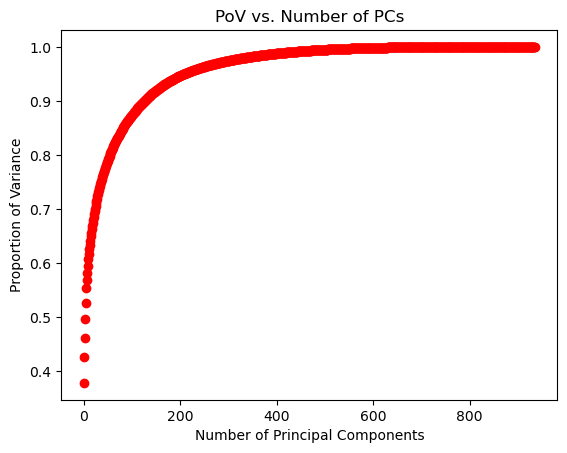

In [78]:
from sklearn.decomposition import PCA

def pca_pov(X):
    # scale X
    scal = StandardScaler()
    X_scaled = scal.fit_transform(X)

    # define nfeatures (ALL)
    nfeat = X.shape[1]

    # pca
    pca = PCA(n_components=nfeat, svd_solver='auto', whiten=True)
    pca.fit(X_scaled)

    # get eigenvalues
    s = pca.singular_values_ # eigenvalues corresponding to the selected components (eigenvectors)

    # calc pov
    denom = np.sum(s**2)
    pov_results = []
    
    for i in range(1, len(s)+1):
        num = np.sum(s[0:i]**2)
        PoV = num / denom
        pov_results.append(PoV)
        
    # show optimal number of components
    for p in [0.95, 0.97, 0.98, 0.99]:
        optimal_nc = np.argmax(np.array(pov_results) >= p) + 1  # +1 bc index starts at 0
        print(f"Optimal ncomponents capturing {p*100}% of Var: {optimal_nc}")


    # plot
    x = range(936)
    plt.scatter(x, pov_results, color='red')
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Proportion of Variance")
    plt.title("PoV vs. Number of PCs")
    plt.show()

pca_pov(X)


In [87]:
np.logspace(-1, -0.01, 10)

array([0.1       , 0.12882496, 0.16595869, 0.21379621, 0.27542287,
       0.35481339, 0.45708819, 0.58884366, 0.75857758, 0.97723722])

# GridSearchCV:
## Hyperparameter tuning: num components & C 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [88]:
# Need to shuffle data bc in order of diagnosis and study site
# Gridsearch CV doesnt not directly suppoirt shuffle
X, y, group_labels = shuffle(X, y, group_labels, random_state=42)

# define objects and pipe
scaler = StandardScaler()
gkf = GroupKFold(n_splits=5)
pca = PCA() 
logreg = linear_model.LogisticRegression(solver='saga', penalty='l1', max_iter=5000) # try saga solver ?
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logreg', logreg)])

# define params to test
ncomp_test = [209, 278, 335, 424]
c_test = np.logspace(-1, -0.01, 10)

# create dict of params
params = {'pca__n_components': ncomp_test, 'logreg__C' : c_test}

# define and fit object estimator gridsearchcv
estimator = GridSearchCV(pipe, params, cv=gkf, return_train_score=True)
estimator.fit(X,y, groups=group_labels)


KeyboardInterrupt: 

In [30]:
print(f"Best test score: {estimator.best_score_:.4f}")
print(f"Best parameters: {estimator.best_params_}")


Best test score: 0.9431
Best parameters: {'logreg__C': 0.14962356560944334, 'pca__n_components': 335}


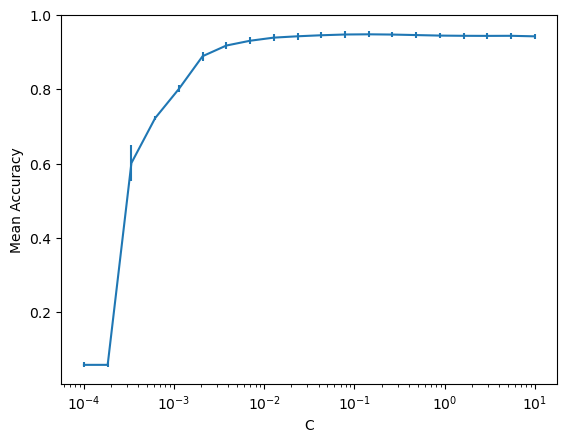

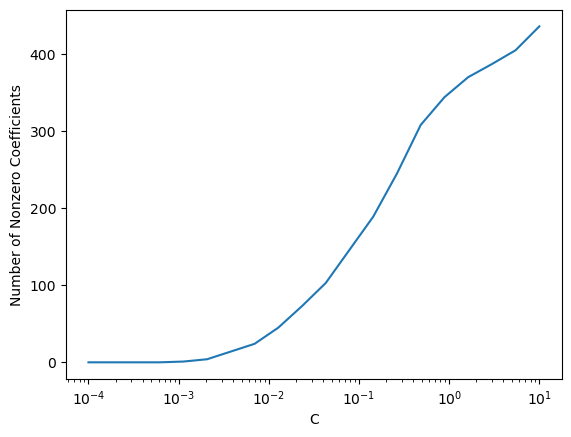

Best C value: 0.1438 with accuracy 0.9480


In [18]:

# Initialize objects
nfold = 10
c_values = np.logspace(-4, 1, 20) # to test out: # smaller C increases regularization

# create group kfold obj
gkf = GroupKFold(n_splits=nfold, shuffle=True, random_state=42) # shuffle = True bc df compiled in order of diagnosis & site
acc = np.zeros((len(c_values), nfold)) # 20 x 10 matrix
W = np.zeros((len(c_values), X.shape[1]))  # Store mean coefficient values # 20 x 936: for every c value, store 936 coefs

for ifold, (train_index, test_index) in enumerate(gkf.split(X, y, group_labels)): # ensure groups are not split into train/test per fold
    # Get training and test data
    Xtr, ytr = X[train_index], y[train_index]
    Xts, yts = X[test_index], y[test_index]

    # Scale the data
    scal = StandardScaler()
    Xtr1 = scal.fit_transform(Xtr)
    Xts1 = scal.transform(Xts)    

    for ic, c in enumerate(c_values):
        # Create and fit model
        logreg = linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=c)
        logreg.fit(Xtr1, ytr) # scaled train data

        # Predict and store accuracy
        yhat = logreg.predict(Xts1) # scaled test data
        acc[ic, ifold] = np.mean(yhat == yts) # per ith c and ith fold

        # Store mean absolute coefficients across folds
        W[ic] += np.abs(logreg.coef_[0]) / nfold  

# Compute mean accuracy for each C
acc_mean = acc.mean(axis=1)
acc_se = acc.std(axis=1) / np.sqrt(nfold)

# Plot accuracy vs. C
plt.errorbar(c_values, acc_mean, yerr=acc_se)
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Mean Accuracy")
plt.show()

# Plot sparsity effect (how many nonzero coefficients)
plt.plot(c_values, np.count_nonzero(W, axis=1))
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Number of Nonzero Coefficients")
plt.show()

# Print best C value
best_c = c_values[np.argmax(acc_mean)]
print(f"Best C value: {best_c:.4f} with accuracy {np.max(acc_mean):.4f}")

In [19]:
best_c_index = np.argmax(acc_mean)
best_c_index

12

In [21]:
indices_non_zero = np.where(W[11,:] > 0)
indices_non_zero[0]
len((indices_non_zero)[0]) # performs best with 144 features

146

# Code Version Save

In [ ]:
# # Version 1

# # define
# groups = df_clean['Participant'].to_numpy()
# X = df_clean.iloc[:,4:].to_numpy() # identifer (window index) gets dropped
# y = np.unique(df_clean['GeneralEvent'], return_inverse=True)[1]# creates classes: 0,1,2,3,4

# # Initialize objects
# nfold = 10
# c_values = np.logspace(-4, 1, 20) # to test out: # smaller C increases regularization

# # create group kfold obj
# gkf = GroupKFold(n_splits=nfold, shuffle=True, random_state=42) # shuffle = True bc df compiled in order of diagnosis & site
# acc = np.zeros((len(c_values), nfold)) # 20 x 10 matrix
# W = np.zeros((len(c_values), X.shape[1]))  # Store mean coefficient values # 20 x 936: for every c value, store 936 coefs

# for ifold, (train_index, test_index) in enumerate(gkf.split(X, y, groups)): # ensure groups are not split into train/test per fold
#     # Get training and test data
#     Xtr, ytr = X[train_index], y[train_index]
#     Xts, yts = X[test_index], y[test_index]

#     # Scale the data
#     scal = StandardScaler()
#     Xtr1 = scal.fit_transform(Xtr)
#     Xts1 = scal.transform(Xts)    

#     for ic, c in enumerate(c_values):
#         # Create and fit model
#         logreg = linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=c)
#         logreg.fit(Xtr1, ytr) # scaled train data

#         # Predict and store accuracy
#         yhat = logreg.predict(Xts1) # scaled test data
#         acc[ic, ifold] = np.mean(yhat == yts) # per ith c and ith fold

#         # Store mean absolute coefficients across folds
#         W[ic] += np.abs(logreg.coef_[0]) / nfold  

# # Compute mean accuracy for each C
# acc_mean = acc.mean(axis=1)
# acc_se = acc.std(axis=1) / np.sqrt(nfold)

# # Plot accuracy vs. C
# plt.errorbar(c_values, acc_mean, yerr=acc_se)
# plt.xscale('log')
# plt.xlabel("C")
# plt.ylabel("Mean Accuracy")
# plt.show()

# # Plot sparsity effect (how many nonzero coefficients)
# plt.plot(c_values, np.count_nonzero(W, axis=1))
# plt.xscale('log')
# plt.xlabel("C")
# plt.ylabel("Number of Nonzero Coefficients")
# plt.show()

# # Print best C value
# best_c = c_values[np.argmax(acc_mean)]
# print(f"Best C value: {best_c:.4f} with accuracy {np.max(acc_mean):.4f}")

# Best 144 Features

In [31]:
# # which columns are associated with these non-zero weights?
# x = df_clean.iloc[:,4:]
# for col in x.columns[indices_non_zero[0]]:
#     print(col)

# Next Steps

## 1) Retry with dropping columns rather than rows
## 2) Retry with just Controls, then test accuracy on PD dataset
## 3) Try for next aim: predicting group